[wikimedia :list of http status codes](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes)


HTTP :
- 1xx:informational response
- 2xx:success
- 3xx:redirection
- 4xx:client error
- 5xx:server error

In [2]:
import zipfile
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

zip_path="../../DATAFLOW_2026_UET.EPOCH_0_AUTOSCALING_ANALYSIS/data/cleaned/data_cleaned.zip"
def read_file(zip_path,filename):
    with zipfile.ZipFile(zip_path,"r") as z :
        with z.open(filename,'r') as f :
            return pd.read_csv(f)
train_df=read_file(zip_path,"train.csv")
test_df=read_file(zip_path,"test.csv")

In [3]:
train_df.head(5)

,index,host,timestamp,request,response,bytes
0,0,199.72.81.55,1995-07-01 00:00:01,GET /history/apollo/ HTTP/1.0,200,6245
1,1,unicomp6.unicomp.net,1995-07-01 00:00:06,GET /shuttle/countdown/ HTTP/1.0,200,3985
2,2,199.120.110.21,1995-07-01 00:00:09,GET /shuttle/missions/sts-73/mission-sts-73.ht...,200,4085
3,3,burger.letters.com,1995-07-01 00:00:11,GET /shuttle/countdown/liftoff.html HTTP/1.0,304,0
4,4,199.120.110.21,1995-07-01 00:00:11,GET /shuttle/missions/sts-73/sts-73-patch-smal...,200,4179


In [4]:
def column_response(df):
    df_response =df[['index','response']].copy()
    df_response ['response']=pd.to_numeric(df_response['response'],errors='coerce',downcast='integer')
    return df_response
train_response=column_response(train_df)
test_response=column_response(test_df)

In [5]:
train_response['response'].unique()

array([200, 304, 302, 404, 403, 500, 501, 400], dtype=int16)

In [6]:
from http import HTTPStatus

def get_response_status(code):
    try:
        response_status = HTTPStatus(code).phrase
    except:
        response_status = HTTPStatus(404).phrase
    return response_status
def get_response_class(code):
    switcher = {
        1: 'informational',
        2: 'successful',
        3: 'redirection',
        4: 'client error',
        5: 'server error',
    }
    code_index = int(str(code)[0])
    response_class = switcher.get(code_index)
    return response_class
def get_response_result(code):
    code_index = int(str(code)[0])
    if code_index in [1, 2, 3]:
        result = 'success'
    else:
        result = 'fail'
    return result


In [7]:
train_response['response_status']=train_response['response'].apply(get_response_status)
test_response['response_status']=test_response['response'].apply(get_response_status)
train_response['response_status'].unique()

<StringArray>
[                   'OK',          'Not Modified',                 'Found',
             'Not Found',             'Forbidden', 'Internal Server Error',
       'Not Implemented',           'Bad Request']
Length: 8, dtype: str

In [8]:
train_response['response_class']=train_response['response'].apply(get_response_class)
test_response['response_class']=test_response['response'].apply(get_response_class)
train_response['response_class'].unique()

<StringArray>
['successful', 'redirection', 'client error', 'server error']
Length: 4, dtype: str

In [9]:
train_response['response_result']=train_response['response'].apply(get_response_result)
test_response['response_result']=test_response['response'].apply(get_response_result)
train_response['response_result'].unique()

<StringArray>
['success', 'fail']
Length: 2, dtype: str

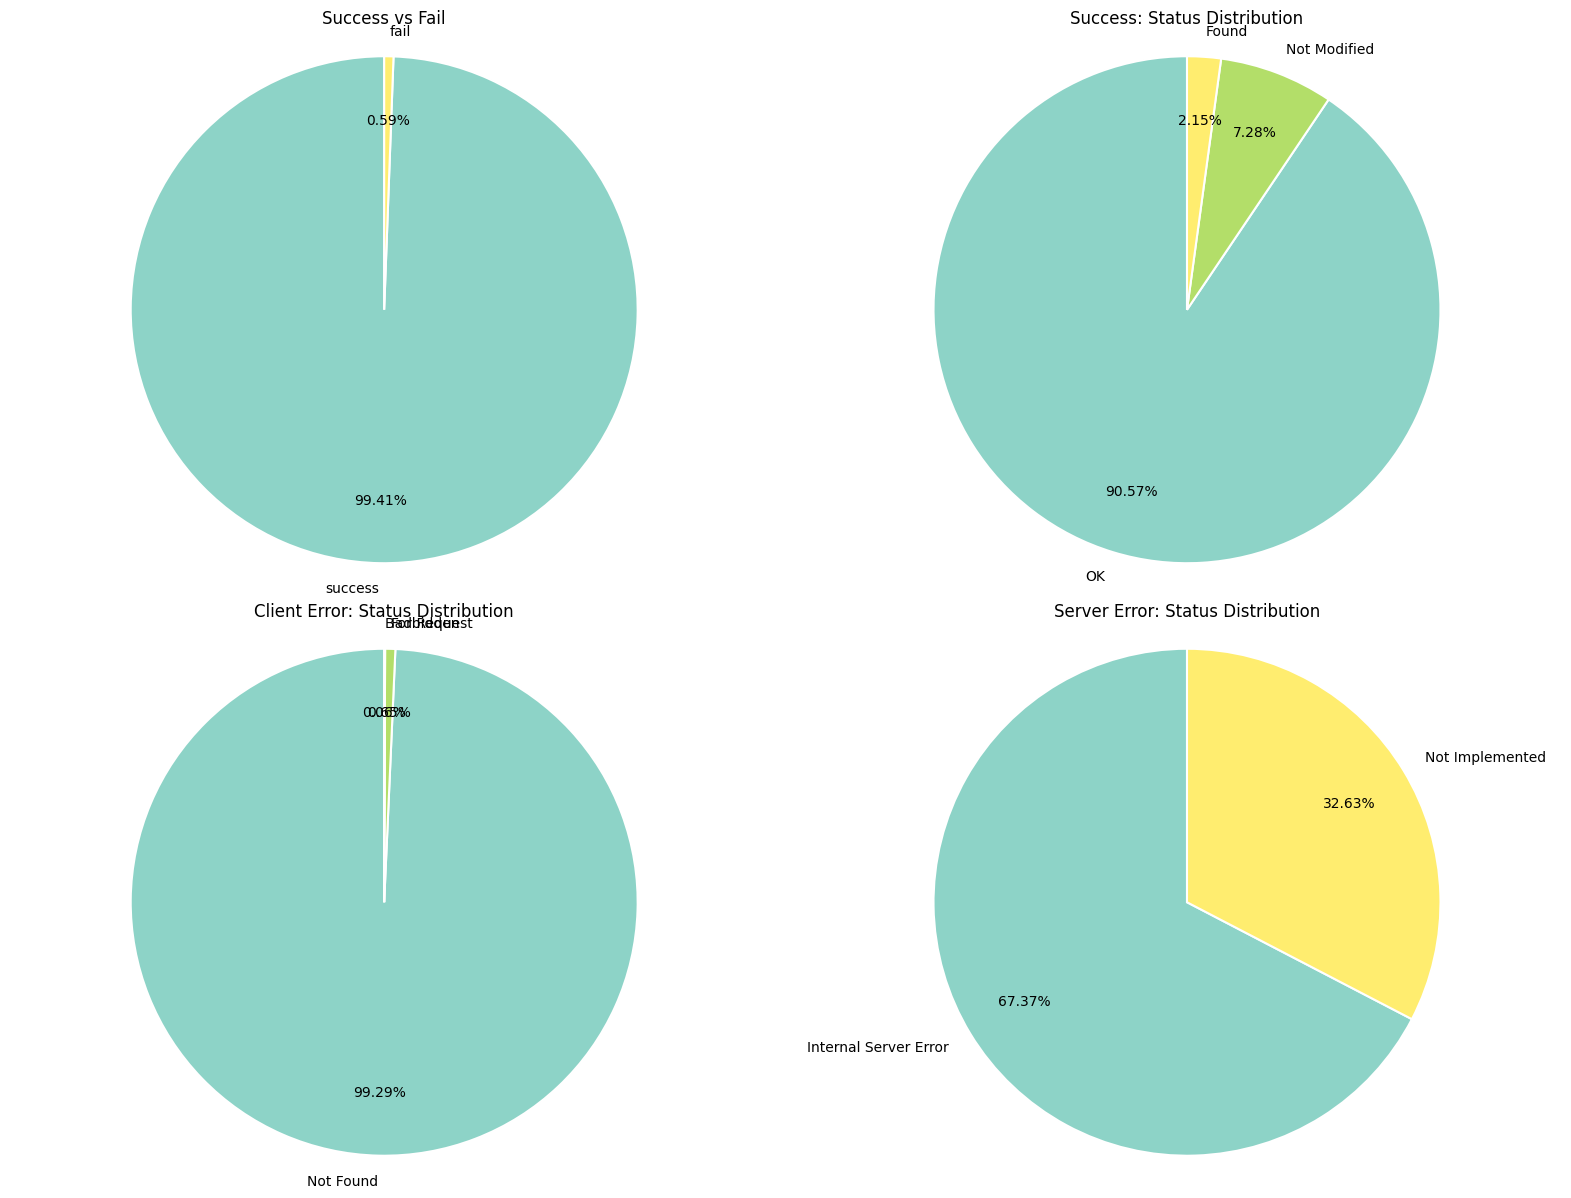

In [10]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
(ax1, ax2), (ax3, ax4) = axes

def pie_with_colors(ax, labels, values, title, cmap_name="tab20"):
    cmap = plt.get_cmap(cmap_name)
    colors = cmap(np.linspace(0, 1, len(labels)))

    ax.pie(
        values,
        labels=labels,
        autopct="%1.2f%%",
        startangle=90,
        pctdistance=0.75,
        colors=colors,
        wedgeprops={"edgecolor": "white", "linewidth": 1.5},  # viền trắng cho đẹp
        textprops={"fontsize": 10},
    )
    ax.set_title(title, fontsize=12, pad=12)
    ax.axis("equal")

# Pie 1: success vs fail
df1 = (train_response.groupby("response_result")["response_result"]
       .count().sort_values(ascending=False).reset_index(name="count"))
labels = df1["response_result"]
values = df1["count"] / df1["count"].sum()
pie_with_colors(ax1, labels, values, "Success vs Fail", cmap_name="Set3")

# Pie 2: success status distribution
df2 = train_response.loc[train_response["response_result"] == "success"]
df2 = (df2.groupby("response_status")["response_status"]
       .count().sort_values(ascending=False).reset_index(name="count"))
labels = df2["response_status"]
values = df2["count"] / df2["count"].sum()
pie_with_colors(ax2, labels, values, "Success: Status Distribution", cmap_name="Set3")

# Pie 3: client error status distribution
df3 = train_response.loc[train_response["response_class"] == "client error"]
df3 = (df3.groupby("response_status")["response_status"]
       .count().sort_values(ascending=False).reset_index(name="count"))
labels = df3["response_status"]
values = df3["count"] / df3["count"].sum()
pie_with_colors(ax3, labels, values, "Client Error: Status Distribution", cmap_name="Set3")

# Pie 4: server error status distribution
df4 = train_response.loc[train_response["response_class"] == "server error"]
df4 = (df4.groupby("response_status")["response_status"]
       .count().sort_values(ascending=False).reset_index(name="count"))
labels = df4["response_status"]
values = df4["count"] / df4["count"].sum()
pie_with_colors(ax4, labels, values, "Server Error: Status Distribution", cmap_name="Set3")

plt.tight_layout()
plt.show()


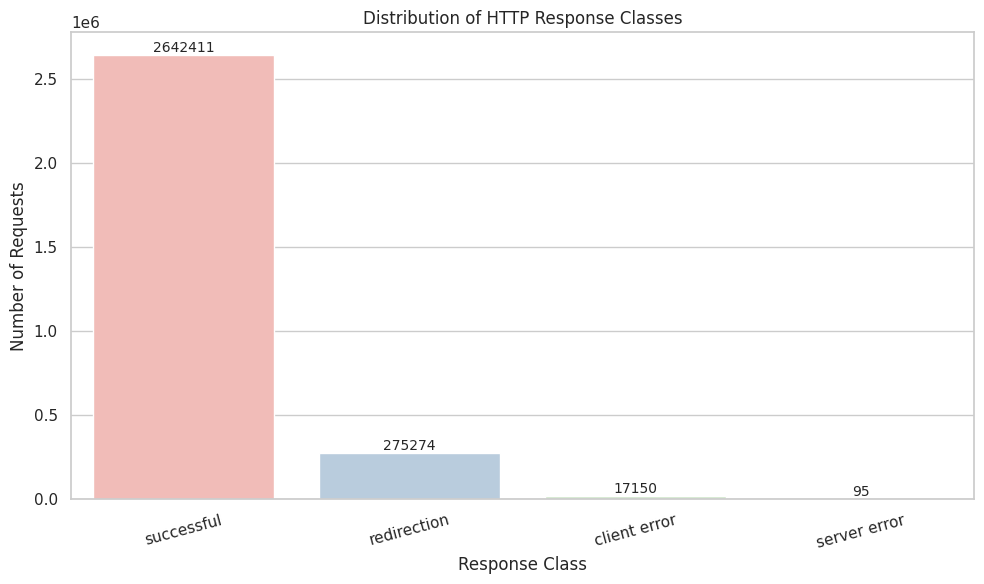

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

counts = train_response["response_class"].value_counts()
plot_df = counts.reset_index()
plot_df.columns = ["response_class", "count"]

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=plot_df, x="response_class", y="count",hue="response_class", palette="Pastel1",legend=False)

ax.set_title("Distribution of HTTP Response Classes")
ax.set_xlabel("Response Class")
ax.set_ylabel("Number of Requests")

plt.xticks(rotation=15)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()


In [12]:
train_response.head(5)

,index,response,response_status,response_class,response_result
0,0,200,OK,successful,success
1,1,200,OK,successful,success
2,2,200,OK,successful,success
3,3,304,Not Modified,redirection,success
4,4,200,OK,successful,success


In [13]:
train_final= train_response[['index', 'response', 'response_class']].copy()
test_final= test_response[['index', 'response', 'response_class']].copy()

In [14]:
train_final.to_parquet(
    "../features/06_response_train.parquet",
    engine="fastparquet",  
    index=False
)